# Проект 12. Определение тональности (токсичности) текста

Нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. <br/>
Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности правок.
Необходиио построитб модель со значением метрики качества F1 не меньше 0.75.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import lightgbm as lgb
import catboost as cb

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import re
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

import imblearn

import spacy

In [2]:
#import nltk
#nltk.download()

In [3]:
try:
    data = pd.read_csv("g:/Projects/praktikum/datasets/toxic_comments.csv")
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Имеем корпус из 160к твитов.
* text - текст твита
* toxic - признак токсичности текста

# 1. Обработка данных

Предобработку данных будем осуществлять по следующей схеме (для каждой строки):
1. Токенизируем текст
2. Лемматизируем токены, используя Spacy
3. Удаляем из лемматизированного текста стоп-слова, используя Gensim.
4. Очищаем текст от лишних символов, за исключением букв английского алфавита и пробелов, c помощью Re.

In [5]:
# грузим английскую модель Spacy
nlp = spacy.load('en')

In [6]:
def clear_text(row):
    text = row['text']
    
    # токенизация
    tokens = nlp(text)
    lemm_result = []
    
    # лемматизация
    lemms_line = " ".join([token.lemma_ for token in tokens])
    
    # удаление стоп-слов
    text_no_sw = remove_stopwords(lemms_line)
    
    # очистка от мусора
    clear_lemms = re.sub(r'[^a-zA-Z]', ' ', text_no_sw)
    clear_text = " ".join(clear_lemms.split())
   
    return clear_text

In [7]:
notebook.tqdm.pandas()
data['clear_lemms'] = data.progress_apply(clear_text, axis=1)

G:\Anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
# выгружаем расширенный фрейм, чтобы не делать обработку каждый раз
data.to_csv('toxic_c_clear2.csv', index=False)

Загрузим подготовленный файл, с очищенным текстом.

In [9]:
data=pd.read_csv('toxic_c_clear2.csv')

#некоторые твиты в исходных данных были некорректны, и в результате получили пустые строки с леммами - выбрасываем
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159518 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         159518 non-null  object
 1   toxic        159518 non-null  int64 
 2   clear_lemms  159518 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [10]:
data.head(2)['clear_lemms'].values

array(['explanation edit PRON username Hardcore Metallica Fan revert PRON vandalism closure gas PRON vote New York Dolls FAC remove template talk page PRON retire now',
       'd aww PRON match background colour PRON seemingly stick thank talk January UTC'],
      dtype=object)

Супер! Приступаем к подготовке к обучению!

## 2. Подготовка признаков (TF-IDF)

In [11]:
corpus = data['clear_lemms']
label = data['toxic']

Посмотрим на распределение целевого признака.

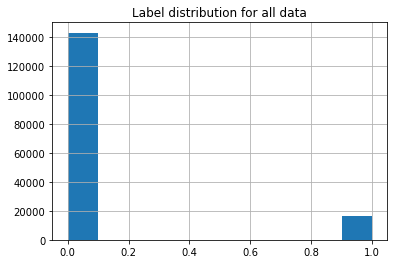

In [12]:
label.hist()
plt.title('Label distribution for all data')
plt.show()

Признак не сбалансирован - токсичных комментариев существенно меньше! Это станет проблемой - вместо обучения определять токсичные слова и словосочетания, модели будут забивать память ненужными данными из обычных комментов. <br/>
Я пробовал использовать следующие методики балансировки:
1. Балансировка весов классов для вероятностных моделей (class_weight)
2. Downsampling более частого класса
3. Upsampling редкого класса
4. Генерация синтетических экземпляров методом SMOTE

Лучшие результаты показал первый способ балансировки, поэтому в работе остался только он. 

Сначала отделим 0.2 комментариев на тестовую выборку.

In [13]:
corpus_train, corpus_test, label_train, label_test = train_test_split(corpus, label, test_size=0.2)
print('Train corpus:', corpus_train.shape)
print('Test corpus:', corpus_test.shape)

Train corpus: (127614,)
Test corpus: (31904,)


Теперь векторизируем признаки. <br/>
Используем алгоритм TF-IDF для получения векторов слов и их встречаемости в комментариях.

In [14]:
# инициализируем векторайзер и фитим на обучающей выборке
count_tfidf = TfidfVectorizer()
count_tfidf.fit(corpus_train)

TfidfVectorizer()

In [15]:
# трансформируем обучающий и тестовый корпуса
tf_idf_train = count_tfidf.transform(corpus_train)
tf_idf_test = count_tfidf.transform(corpus_test)

print('Train corpus', tf_idf_train.shape)
print('Label train', label_train.shape)
print('---')
print('Test corpus', tf_idf_test.shape)
print('Test label', label_test.shape)

Train corpus (127614, 138421)
Label train (127614,)
---
Test corpus (31904, 138421)
Test label (31904,)


Данные готовы к обучению моделей!

# 3. Обучение и тестирование моделей

In [16]:
# функция для теста. На вход - модель, на выходе метрики и ROC-график
def test_me(cur_model):    
    #probs and ROC-AUC
    probabilities_test = cur_model.predict_proba(tf_idf_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(label_test, probabilities_one_test)
    
    # F1 score
    predictions = cur_model.predict(tf_idf_test)
    f1 = f1_score(label_test, predictions)
    print('F1_Score=', f1)
    
    #график
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
            
    # AUC-ROC SCORE
    auc_roc = roc_auc_score(label_test, probabilities_one_test)
    print('ROC-AUC Score=', auc_roc)
    
    plt.show()
    return f1

In [17]:
# таблица с результатами
result = pd.DataFrame(columns = ['F1_score'])

## 3.1 Logistic Regression

In [18]:
model_lr = LogisticRegression(random_state=112211, max_iter=1000, class_weight='balanced')
model_lr.fit(tf_idf_train, label_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=112211)

F1_Score= 0.753568030447193
ROC-AUC Score= 0.9726067891590335


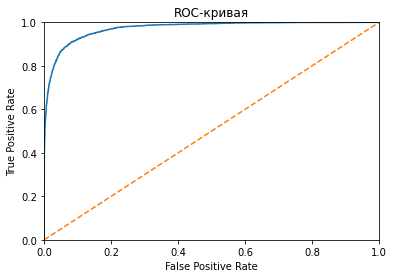

In [19]:
f1_lr = test_me(model_lr)

In [20]:
# собираем результаты тестов в табличку
result.loc['LogRegression'] = f1_lr
result

,F1_score
LogRegression,0.753568


## 3.2 RandomForestClassifier

In [21]:
# функция для обучения gridsearch
def RFC_grid(feat, targ):
    estimator = RandomForestClassifier(random_state=112211)
    param_grid = {
            "n_estimators"      : [500,1000],
            "max_features"      : ["auto"],
            "min_samples_leaf" : [1],
            "min_samples_split" : [10,20],
            "bootstrap": [False],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring='f1')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [22]:
#RFC_params = RFC_grid(tf_idf_train, label_downsampled)
RFC_params = {'bootstrap': False, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 200, 'class_weight':'balanced'}

In [23]:
model_rfc = RandomForestClassifier(**RFC_params)
model_rfc.fit(tf_idf_train, label_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_split=10, n_estimators=200)

F1_Score= 0.6954252913550182
ROC-AUC Score= 0.9594755892101204


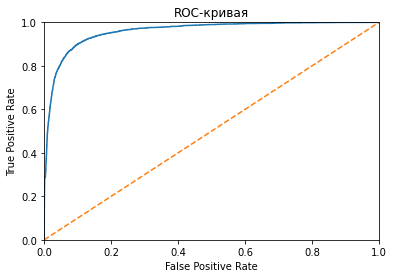

In [24]:
f1_rfc = test_me(model_rfc)

In [25]:
result.loc['RFClassifier'] = f1_rfc
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425


## 3.3 Linear Support Vector Classifier

In [26]:
model_svc = LinearSVC(tol=1e-5, class_weight='balanced')
model_svc.fit(tf_idf_train, label_train)

predict = model_svc.predict(tf_idf_test)
f1_score(label_test, predict)

0.7560627674750358

In [27]:
result.loc['LinearSVC'] = f1_score(label_test, predict)
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425
LinearSVC,0.756063


## 3.4 AdaBoostClassifier

In [29]:
model_abc = AdaBoostClassifier(n_estimators=200, learning_rate=1)
model_abc.fit(tf_idf_train, label_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

F1_Score= 0.7247261626862992
ROC-AUC Score= 0.9422037816717025


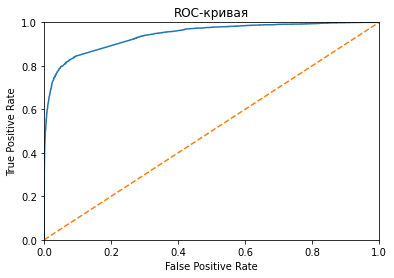

In [30]:
f1_ada = test_me(model_abc)

In [31]:
result.loc['AdaBoostClassifier'] = f1_ada
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425
LinearSVC,0.756063
AdaBoostClassifier,0.724726


## 3.5 LightGBM

In [32]:
lgb_params = {'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 1, 'num_leaves': 500, 'reg_lambda': 5}
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(tf_idf_train, label_train)

LGBMClassifier(min_child_weight=1, num_leaves=500, reg_lambda=5)

F1_Score= 0.767321613236815
ROC-AUC Score= 0.96651176907802


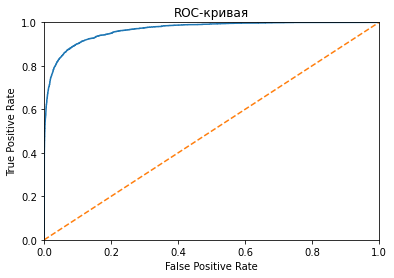

In [33]:
f1_lgb = test_me(model_lgb)

In [34]:
result.loc['LightGBM'] = f1_lgb
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425
LinearSVC,0.756063
AdaBoostClassifier,0.724726
LightGBM,0.767322


## 3.6 Catboost

In [35]:
cb_params = {'depth': 6, 'iterations': 1000, 'learning_rate': 0.4, 'verbose':100}
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(tf_idf_train, label_train)

0:	learn: 0.3731980	total: 873ms	remaining: 14m 32s
100:	learn: 0.1232283	total: 1m 15s	remaining: 11m 11s
200:	learn: 0.1051070	total: 2m 29s	remaining: 9m 53s
300:	learn: 0.0939368	total: 3m 43s	remaining: 8m 38s
400:	learn: 0.0873267	total: 4m 57s	remaining: 7m 24s
500:	learn: 0.0817309	total: 6m 10s	remaining: 6m 9s
600:	learn: 0.0774029	total: 7m 23s	remaining: 4m 54s
700:	learn: 0.0731797	total: 8m 37s	remaining: 3m 40s
800:	learn: 0.0693951	total: 9m 51s	remaining: 2m 26s
900:	learn: 0.0653348	total: 11m 5s	remaining: 1m 13s
999:	learn: 0.0622128	total: 12m 18s	remaining: 0us


F1_Score= 0.7731208867336334
ROC-AUC Score= 0.9645392452670016


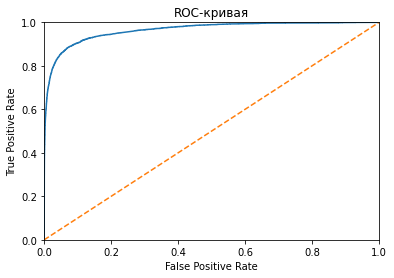

In [36]:
f1_cb = test_me(model_cb)

In [37]:
result.loc['CatBoost'] = f1_cb
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425
LinearSVC,0.756063
AdaBoostClassifier,0.724726
LightGBM,0.767322
CatBoost,0.773121


# 4. Выводы

Целью работы было построение модели для определения тональности(токсичности) комментариев. <br/>
Входные данные: корпус из 160к комментариев.

Для подготовки к обучению моделей, была проведена обработка данных:
1. Токенизация текста
2. Лемматизация токенов, используя Spacy
3. Очистка текста от стоп-слов и лишних символов
4. Векторизация методом TF-IDF

Полученные данные были разбиты на тренировочную и тестовую выборку (5:1). <br/>
Для балансировки целевых классов использовалась методика балансировки весов классов (class_weight).

Далее были обучены и протестированы различные модели. Для оценки качества тестирования использовалась метрика F1. <br/>
Результаты тестирования:

In [39]:
result

,F1_score
LogRegression,0.753568
RFClassifier,0.695425
LinearSVC,0.756063
AdaBoostClassifier,0.724726
LightGBM,0.767322
CatBoost,0.773121
